Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
original_test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, original_test.shape

((59400, 41), (14358, 40))

In [3]:
#val and train split
original_train, original_val = train_test_split(train, train_size=.8, test_size=.2,
                              stratify=train['status_group'], random_state=42)
original_train.shape, original_val.shape, original_test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
import numpy as np

def better_wrangle(x):
    x = x.copy()

    x['latitude'] = x['latitude'].replace(-2e-08, 0)

    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        x[col] = x[col].replace(0, np.nan)

    x = x.drop(columns='quantity_group')
    #daterecorded is listed as categorical so putting into datetime format
    x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)
    x['recorded_year'] = x['date_recorded'].apply(lambda x: x.year)
    x['recorded_month'] = x['date_recorded'].apply(lambda x: x.month)
    x['recorded_day'] = x['date_recorded'].apply(lambda x: x.day)
    x['recorded_weekday'] = x['date_recorded'].apply(lambda x: x.weekday())

    #changing the year recorded to the mean, if it is 2004 or 2002
    x['recorded_year'] = x['recorded_year'].replace([2002, 2004], np.nan)
    x['recorded_year'] = x['recorded_year'].replace(np.nan, round(x['recorded_year'].mean()))
    
    #getting how old each is
    x['construction_year_for_age'] = x['construction_year'].replace(0, np.nan)
    x['construction_year_for_age'] = x['construction_year_for_age'].replace(np.nan, round(x['construction_year_for_age'].mean()))
    x['age'] = x['recorded_year'] - x['construction_year_for_age']
    

    #making the times categorical so can use for one hot
    x['recorded_year'] = x['recorded_year'].apply(lambda x: str(x))
    x['recorded_month'] = x['recorded_month'].apply(lambda x: str(x))
    x['recorded_day'] = x['recorded_day'].apply(lambda x: str(x))
    x['recorded_weekday'] = x['recorded_weekday'].apply(lambda x: str(x))
    x['age'] = x['age'].apply(lambda x: str(x))
    x['construction_year'] = x['construction_year_for_age'].apply(lambda x: str(x))
    
    #some variables that i think should be categorical are numerical
    x['region_code'] = x['region_code'].apply(lambda x: str(x))
    x['district_code'] = x['district_code'].apply(lambda x: str(x))

    #fixing the high cardinality
    cardinality = x.select_dtypes(exclude='number').nunique()
    need_to_fix_cardinality = cardinality[cardinality >=50].index.tolist()
    
    for each in need_to_fix_cardinality:
        top25 = x[each].value_counts()[:25].index.to_list()
        x[each] = x[each].apply(lambda y: 'Other' if y not in top25 else y)

    #lumping all the ones that have at least one private together
    x['num_private'] = x['num_private'].apply(lambda x: x if x == 0 else 1)

    #amount tsh has some outliers so going to replace them with the average
    x['amount_tsh'] = x['amount_tsh'].apply(lambda x: x if x<= 1000 else np.nan)
    #dropping duplicates and unwanted columns
    x = x.drop(columns=['payment_type', 'source_type', 'waterpoint_type_group',
                        'extraction_type_group', 'extraction_type_class',
                        'date_recorded', 'recorded_by', 'construction_year_for_age',
                        'source_class', 'quality_group'])
    return x



train = better_wrangle(original_train)
val = better_wrangle(original_val)
test = better_wrangle(original_test)

In [5]:
import pandas_profiling
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(val, minimal=True).to_notebook_iframe()

profile

In [0]:
target = 'status_group'

train_features = train.drop(columns=[target, 'id'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [15]:
#using random forest classifier gives a better result
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

y_pred = pipeline.predict(X_test)

Train Accuracy 0.9989478114478114
Validation Accuracy 0.8127104377104377


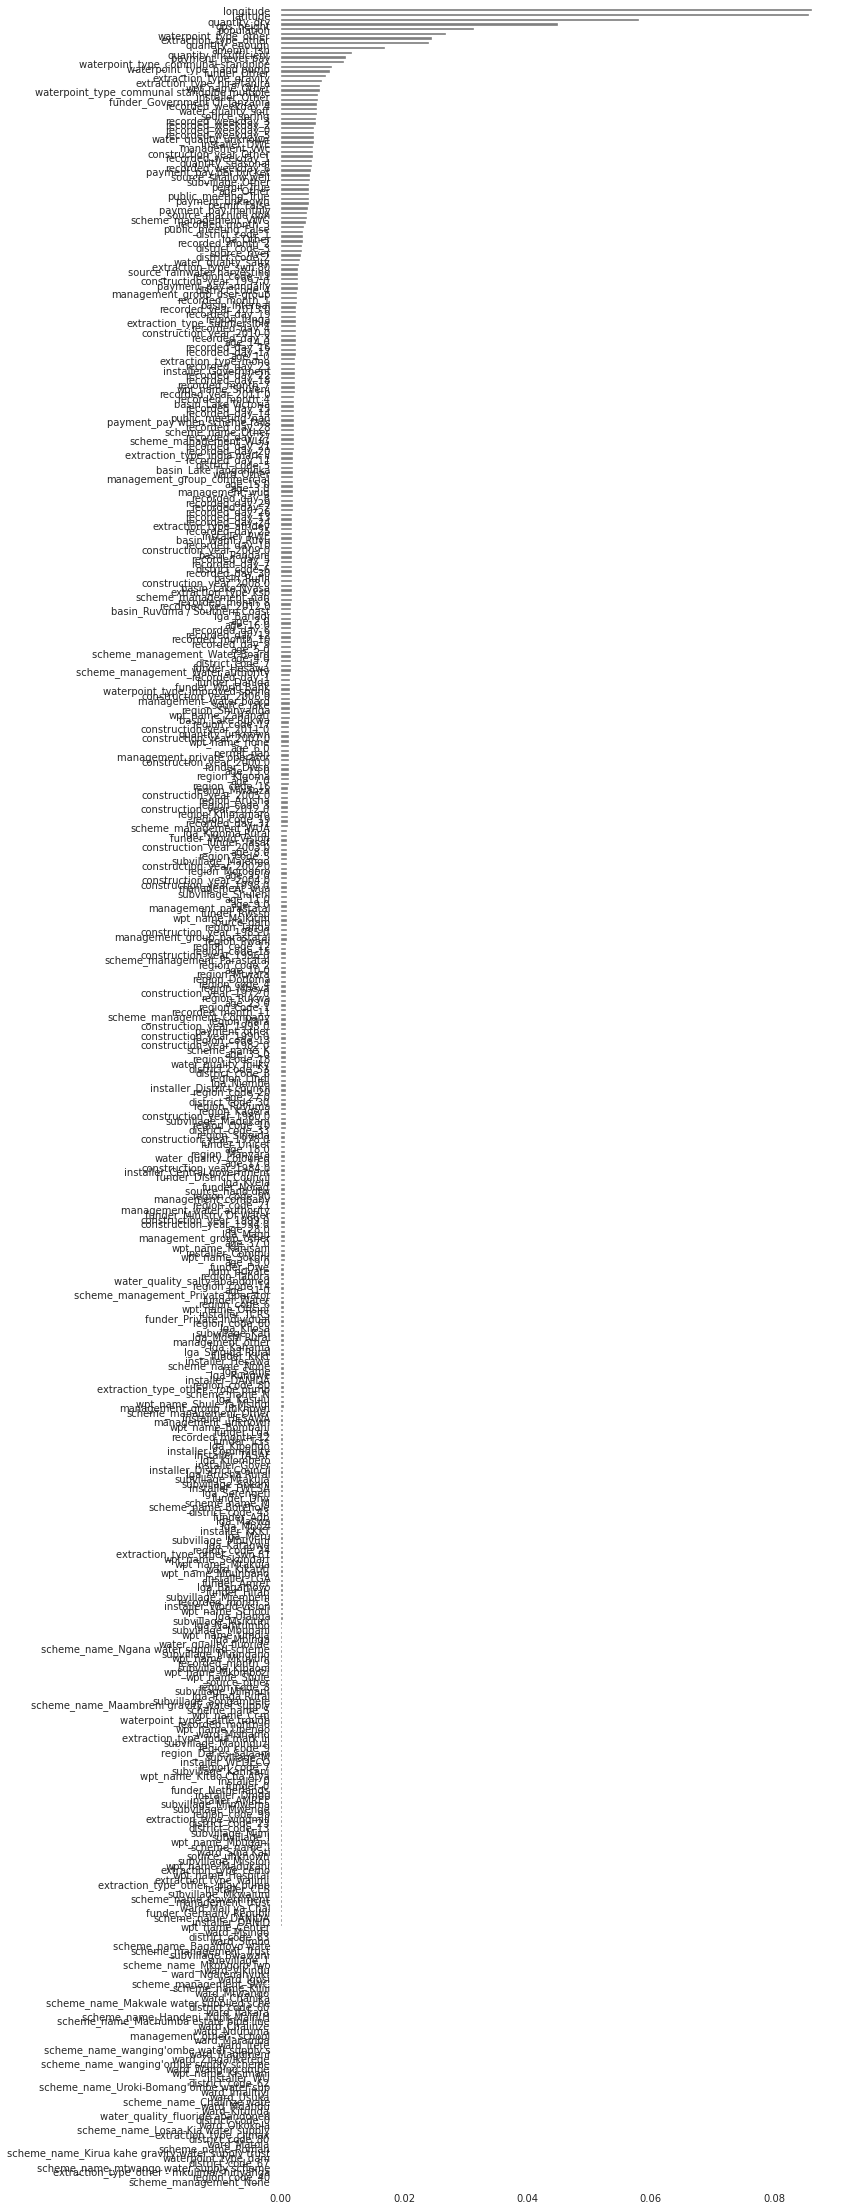

In [8]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 40))
importances.sort_values().plot.barh(color='grey');

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 16.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 42.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
  

In [14]:
search.best_params_, search.best_score_

({'randomforestclassifier__max_depth': 20,
  'randomforestclassifier__max_features': 0.18710698509938484,
  'randomforestclassifier__n_estimators': 488,
  'simpleimputer__strategy': 'median'},
 0.8023569023569023)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('second.csv', index=False)

from google.colab import files
files.download('second.csv')